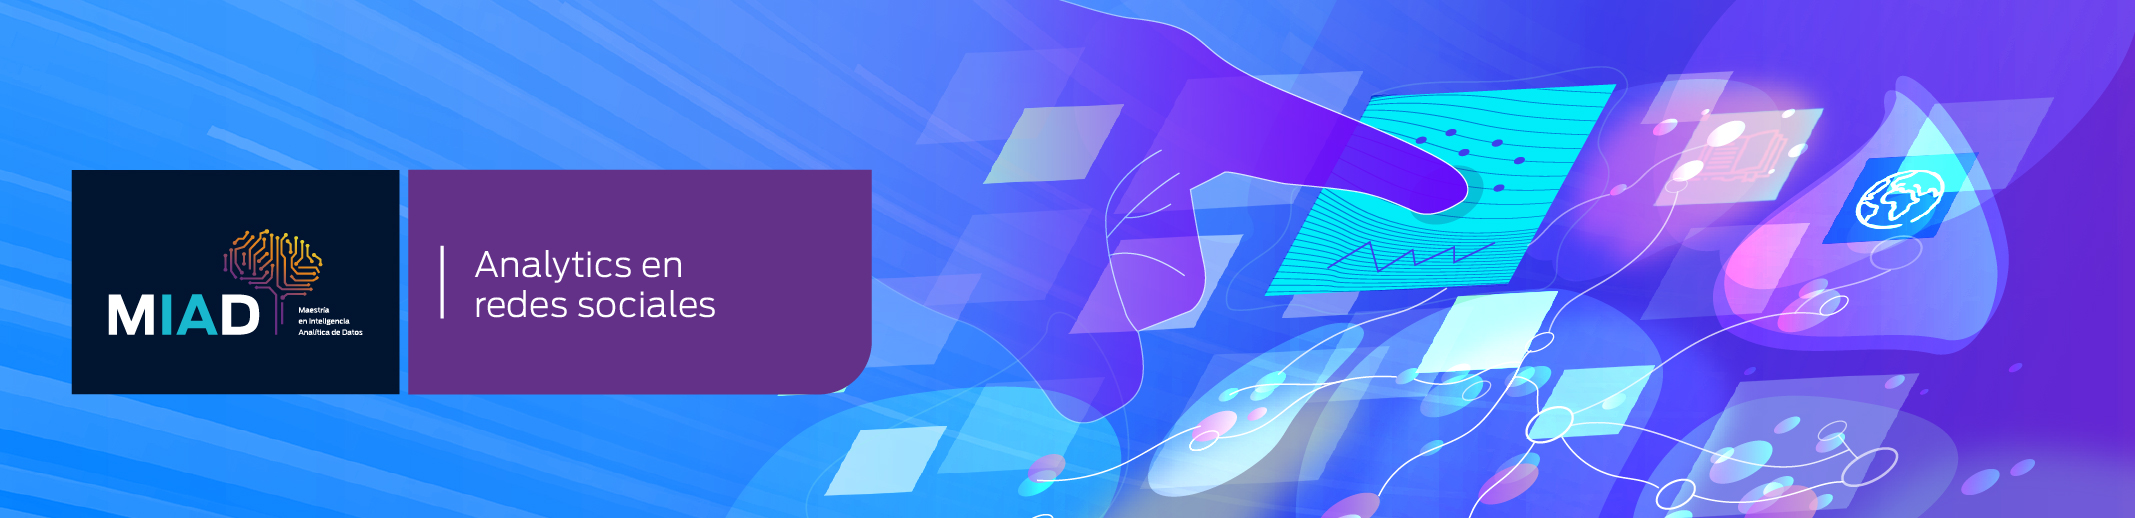

# Tutorial: Identificación de la relación entre las comunidades identificadas y sus atributos

En este notebook usted aprenderá a encontrar relaciones entre las características o atributos de los individuos dentro de una red y la comunidad a la que pertenecen.

Este cuaderno está diseñado como una guía para que detecte las comunidades subyacentes de la estructura de la red y, posterior a esto, sea capaz de identificar qué características pueden enlazar a estas comunidades. Para lo anterior, se realizarán dos tipos de análisis: uno visual donde se comparan las comunidades con los atributos de cada nodo, y uno numérico donde se podrá validar las relaciones vistas en el análisis visual.

#### Expectativas del tutorial
En este tutorial esperamos que usted logre adquirir las siguientes habilidades:
+ Visualizar claramente en la red las comunidades mediante su posición.
+ Colorear los atributos de los nodos de la visualización de la red.
+ Guardar los atributos de los nodos en un DataFrame de Pandas.
+ Estudiar la distribución de los atributos por comunidad.

#### Tabla de contenido
+ [Inicialización](#iniciar)
+ [Posicionamiento de los nodos](#pos)
+ [Visualización de los atributos](#atri)
+ [Guardar atributos en un DataFrame](#df)
+ [Analizar las frecuencias de los atributos en las comunidades](#frec)


<a id = "iniciar"></a>
### Inicialización
Importemos las librerías con las que ya nos hemos familiarizado.

In [1]:
# Importar las librerias a usar
import networkx as nx
import matplotlib.pyplot as plt
import community
import pickle
import pandas as pd

Importemos el pickle que contiene la red sobre la cual vamos a trabajar, guardándola en la variable ``G``.

In [2]:
# Importar el archivo pickle para utilizar la red
networokfile=open('./Red Desempeño.pkl','rb')
G=pickle.load(networokfile)
networokfile.close()

La red en la que vamos a trabajar es la red de desempeño en un call-center. En esta red los nodos corresponden a los empleados y los arcos son las relaciones de amistad entre los empleados. Cada nodo tiene dos atributos: la *Calificación* que muestra la calificación de desempeño (de cero a diez), y el *Sexo* si es mujer (1) u hombre (0).

In [3]:
# Veamos la información de un nodo
G.nodes[7]

{'Sexo': 0, 'Calificación': 2}

Visualicemos la red.

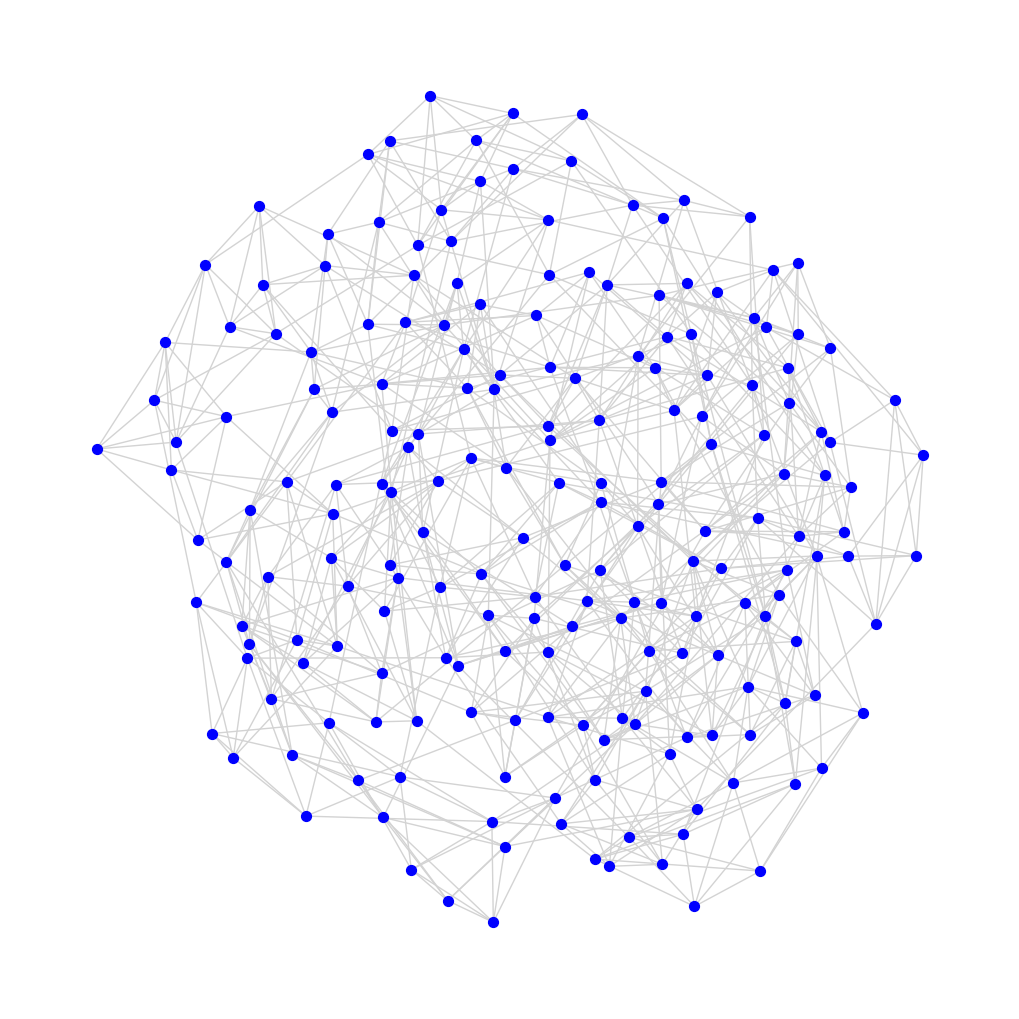

In [4]:
# Dimencionar gráfica
plt.figure(figsize=(10,10))

# Graficar la red con los colores de cada nodo representando las comunidades
nx.draw_kamada_kawai(G, node_color='blue', node_size=50, edge_color='lightgray')

<a id = "pos"></a>
### Posicionamiento de los nodos

Para poder estudiar de forma gráfica los atributos de los nodos es importante poder graficar bajo dos características:
1. Posicionar las comunidades de forma en que se puedan visualizar.
2. Poder replicar esa misma posición de los nodos, para colorearlos a partir de diferentes atributos.

Para lograr la primera característica vamos a usar el siguiente código basado en el siguiente [artículo](https://stackoverflow.com/questions/43541376/how-to-draw-communities-with-networkx). Esta serie de funciones devuelve como resultado el diccionario con las posiciones que permitirán visualizar las comunidades claramente.


In [5]:
def community_layout(g, partition):

    pos_communities = _position_communities(g, partition, scale=3.)

    pos_nodes = _position_nodes(g, partition, scale=1.)

    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]

    return pos

def _position_communities(g, partition, **kwargs):

    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    pos_communities = nx.spring_layout(hypergraph, **kwargs)

    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos

def _find_between_community_edges(g, partition):

    edges = dict()

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges

def _position_nodes(g, partition, **kwargs):
    
    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)

    return pos

El siguiente paso es correr un algoritmo para detectar las comunidades. Para este ejemplo vamos a usar el algoritmo de Louvain.

In [10]:
# Correr el algoritmo de Louvain
partition = community.best_partition(G)

Guardamos en cada nodo a cuál comunidad pertenece.

In [11]:
# Guardar la infomación de la comunidad en cada nodo
for nodo in G.nodes:
    # Agregamos la comunidad en cada nodo
    G.nodes[nodo]['Comunidad']=partition.get(nodo)

Una vez definido el ``partition`` podemos lograr la segunda característica. Para lo anterior, hacemos uso de la función de posición que definimos anteriormente, y guardamos el diccionario resultante de posiciones en la variable ``pos``.

In [12]:
# Posiciones de los nodos
pos=community_layout(G, partition)

Con las posiciones definidas, el siguiente paso es graficar la red. Para esto, usamos la función ``nx.draw()`` que es la función que permite posicionar los nodos como deseemos.

Vamos a colocar dentro de la función el diccionario ``pos`` definido anteriormente y cololearemos los nodos a partir de las comunidades de cada nodo.

El procedimiento es el siguiente:

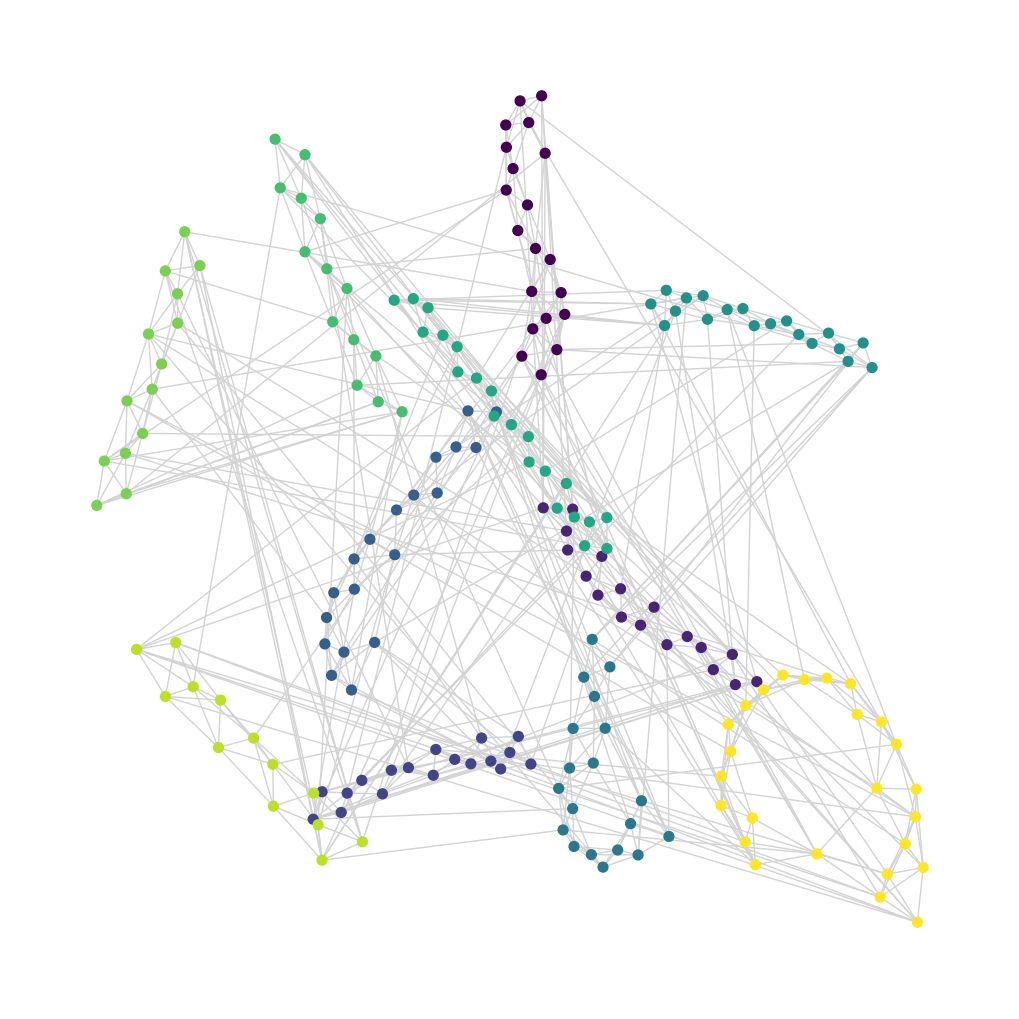

In [13]:
# Dimensionar gráfica
plt.figure(figsize=(10,10))

# Graficar la red con los colores de cada nodo representando las comunidades
nx.draw(G, pos=pos, node_color=list(partition.values()), node_size=50, edge_color='lightgray')

<a id = "atri"></a>
### Visualización de los atributos

Ya hemos visto cómo guardar las posiciones de los nodos. Ahora veamos cómo generar una lista que nos permita colorear los nodos dependiendo de alguno de sus atributos.

En este punto es importante recordar que los nodos en la red cuentan con dos atributos: la calificación y el sexo.

A continuación, cololearemos los nodos a partir del sexo. Para esto hacemos uso de la función ``G.nodes(data='Sexo')`` que nos regresa la información del atributo que nos interesa de todos los nodos. Para consultar la información fácilmente, convertimos esa información en un diccionario mediante la función ``dict()`` y llamamos la información del nodo que requerimos mediante la función ``.get()``. Por último, guardamos la información en una lista de forma iterativa, el resultado se ve a continuación:


In [14]:
# Guardamos los colores
colores = [dict(G.nodes(data='Sexo')).get(node) for node in G.nodes()]

Con los colores definidos, en la función ``nx.draw()`` insertamos esa lista en el atributo *node_color*, sin olvidar volver a utilizar la posición definida anteriormente.

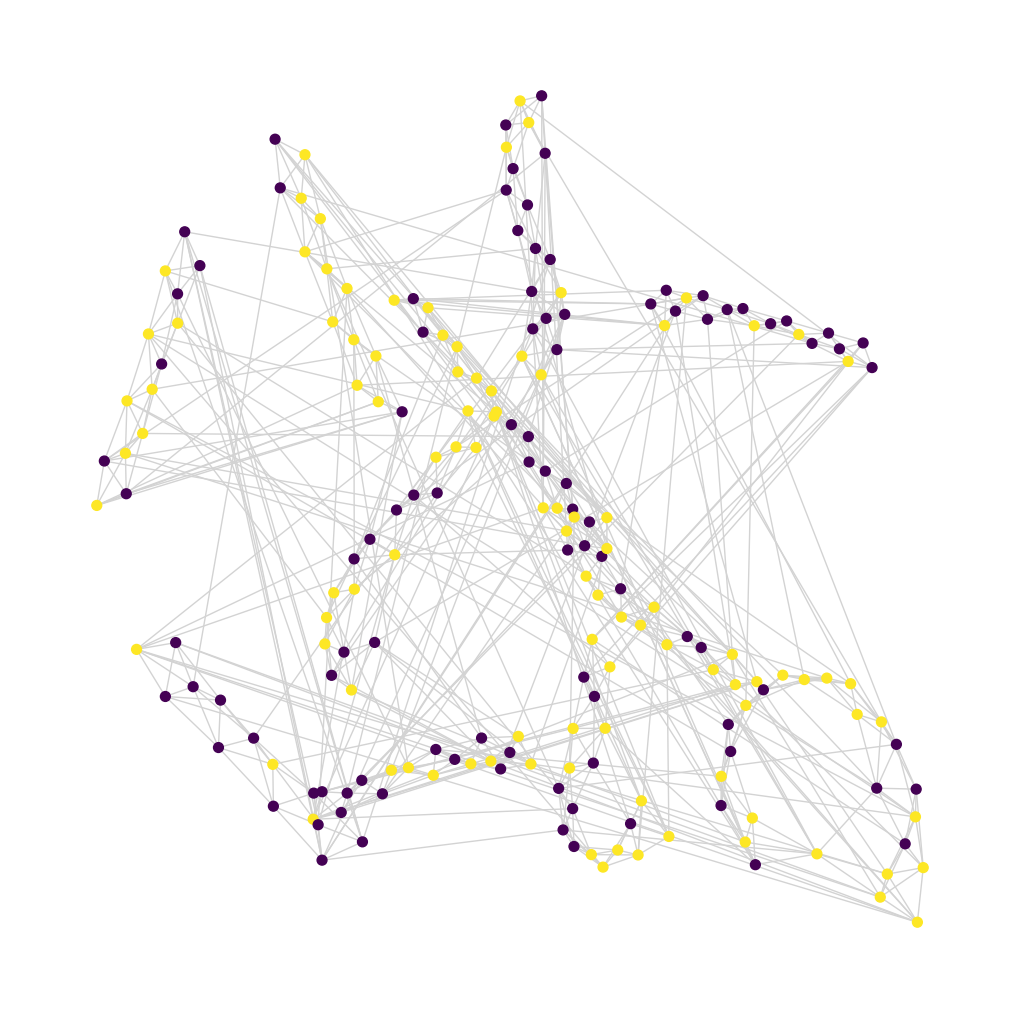

In [15]:
# Dimensionar gráfica
plt.figure(figsize=(10,10))

# Graficar la red con los colores de cada nodo representando el sexo
nx.draw(G, pos, node_color=colores, node_size=50, edge_color='lightgray')

Hagamos ahora el mismo ejercicio con la variable *Calificación*.

In [16]:
# Guardamos los colores
colores = [dict(G.nodes(data='Calificación')).get(node) for node in G.nodes()]

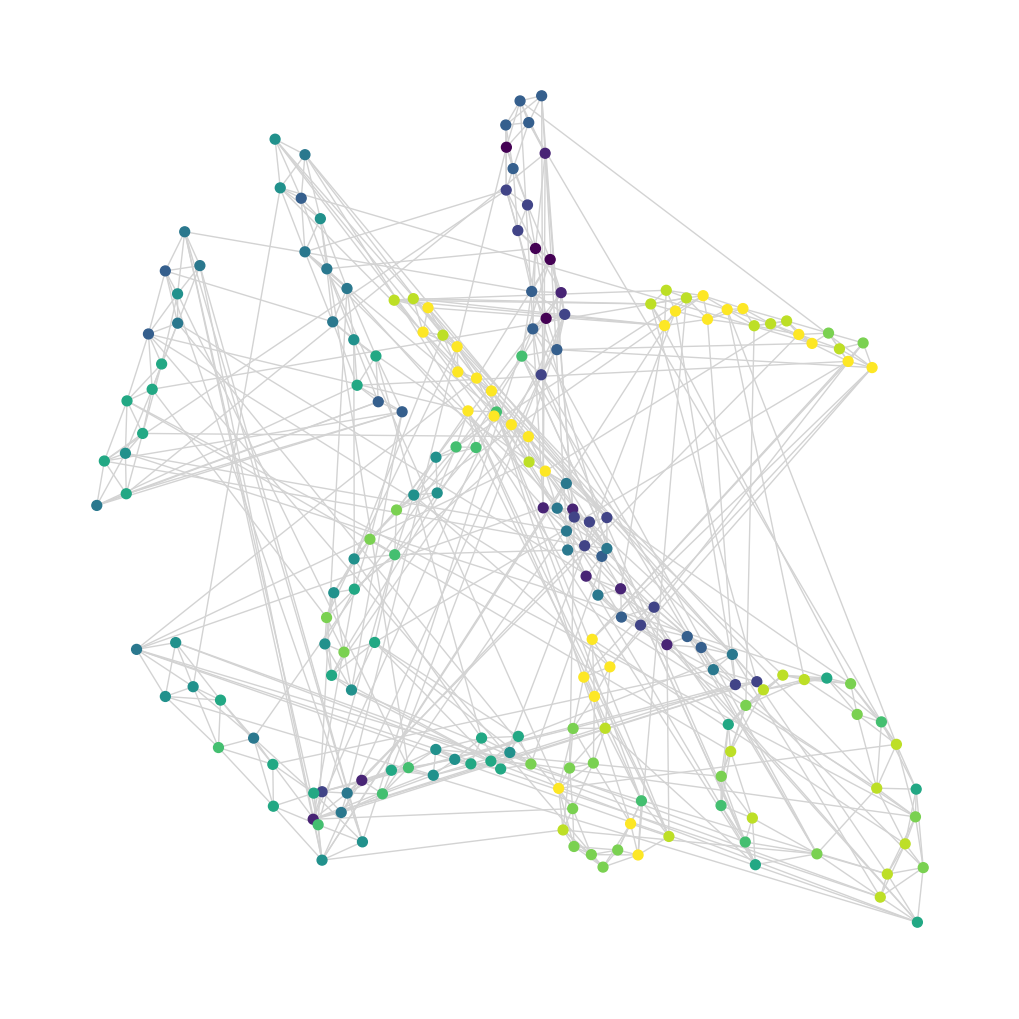

In [17]:
# Dimensionar gráfica
plt.figure(figsize=(10,10))

# Graficar la red con los colores representando la calificación
nx.draw(G, pos, node_color=colores, node_size=50, edge_color='lightgray')

Como podemos observar, a partir del sexo no se ve una relación clara entre la comunidad y el sexo dado que en cada comunidad vemos que la distribución del sexo es similar. Por otra parte, si se ve una relación clara entre la comunidad y la calificación, lo que nos dice que la gente se relaciona con colegas con calificaciones similares.

<a id = "df"></a>
### Guardar atributos en un DataFrame

Para poder ver numéricamente los resultados anteriores, es importe transformar la información en un formato que permita analizarlos fácilmente. Para esto usaremos Pandas, donde en un DataFrame guardaremos la información de la comunidad a la que pertenece el nodo, el sexo y su calificación. Lo anterior los podemos realizar con la siguiente función.


In [18]:
# Guardar en un DataFrame la infrormación de los nodos
Comunidades=pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')
Comunidades

,Sexo,Calificación,Comunidad
0,0,0,0
1,0,2,0
2,1,1,0
3,0,3,0
4,0,0,0
...,...,...,...
195,1,8,10
196,1,7,0
197,1,2,0
198,0,3,0


<a id = "frec"></a>
### Analizar las frecuencias de los atributos en las comunidades

Con el DataFrame generado podemos estudiar los atributos para cada comunidad.

Comencemos estudiando el sexo para cada comunidad. Utilicemos la función ``pivot_table()`` de pandas, donde el **index** es la *Comunidad*, las **columns** son el *Sexo*, los **values** pueden ser cualquier otra columna como por ejemplo *Calificación* y por último la función de agregación **aggfunc** es *count*.


In [19]:
# Tabla descriptiva del sexo por comunidades
Comunidades.pivot_table(index='Comunidad', columns='Sexo', values='Calificación', aggfunc='count')

Sexo,0,1
Comunidad,,
0,14,6
1,6,12
2,10,8
3,8,11
4,8,11
5,14,5
6,9,12
7,3,11
8,6,8


Como podemos ver no hay una distinción clara en cada comunidad, dado que todas tienen una proporción de hombres y mujeres diferente. Por lo tanto, no es posible concluir que las comunidades se estén generando a partir del sexo.

Realicemos el mismo ejercicio con la calificación.


In [20]:
# Tabla descriptiva de la calificación por comunidades
Comunidades.pivot_table(index='Comunidad', values='Sexo', columns='Calificación', aggfunc='count').fillna(0)

Calificación,0,1,2,3,4,5,6,7,8,9,10
Comunidad,,,,,,,,,,,
0,4.0,2.0,5.0,8.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,5.0,4.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,2.0,1.0,0.0,2.0,4.0,6.0,2.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,7.0,3.0,4.0,4.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.0,3.0,7.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,7.0,10.0
6,0.0,0.0,4.0,0.0,3.0,0.0,0.0,0.0,0.0,4.0,10.0
7,0.0,0.0,0.0,3.0,5.0,4.0,2.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,2.0,4.0,2.0,6.0,0.0,0.0,0.0,0.0


Esta vez si es posible ver que en cada comunidad los nodos tienden a tener calificaciones similares. Cada comunidad posee rangos de calificaciones concentradas en unas notas, esto nos está diciendo que las calificaciones pueden ser una de las variables que esté generando comunidades.